Intention of this Notebook ist to evaulate the performance of the best performing model, as it was derived through hypertunung.

Comparison Hypertuning advanced:
 *  Model with batch size 512, ResNet type, (256,512) filter counts per CNN stage, global max pool and 3 fully connected layers: MAE: 5.721332726293479, RMSE: 8.31834661119527

# Set up notebook and environment: 

### Connect to google drive: ###

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras #where?
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.image as mpimg
from keras.utils import plot_model
from sklearn import preprocessing
import gc
from sklearn.model_selection import KFold
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Specify location of all relevant data: (YOU HAVE TO INSERT YOUR FILE LOCATIONS) ###

In [0]:
print("Check correctnes of locations: ")
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
model_saves_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/"
data_filter_location = data_folder_location+"merck_and_co_dup_aa_concat_filter.npy"
X_location = data_folder_location+"X.npy"
y_location = data_folder_location+"y_growth_avg.npy"
print(os.path.isdir(data_folder_location))
print(os.path.isdir(model_saves_folder_location))
print(os.path.isfile(data_filter_location))
print(os.path.isfile(X_location))
print(os.path.isfile(y_location))

Check correctnes of locations: 
True
True
True
True
True


### Function to easily retrieve cleaned data with split either from drive or cache, depending wheter data was already retrieved using this function ###

In [0]:
def retrieve_data(X_loc, y_loc, test_split=0.2, random_state=42):
  if not(os.path.isfile("X_train_H.npy")):
    #Load data from drive
    print("Loading data from drive...")
    X_load = np.load(X_loc)
    y_load = np.load(y_loc)
    filter_load = np.load(data_filter_location)
    
    #Apply pre filter
    X_load = X_load[filter_load]
    y_load = y_load[filter_load]
    gc.collect()
    
    #Remove all entries that have no temperature information #can happen, since for some organism specific temperature information is not available
    temp_label_filter = np.logical_not(np.isnan(y_load))
    X_load = X_load[temp_label_filter]
    y_load = y_load[temp_label_filter]
    gc.collect()
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=test_split, random_state=random_state) 
    
    #Cache data
    print("Caching data...")
    np.save('X_train_H.npy', X_train)   
    np.save('X_test_H.npy', X_test)   
    np.save('y_train_H.npy', y_train)   
    np.save('y_test_H.npy', y_test) 
    
    return X_train, X_test, y_train, y_test
  else:
    print("Loading data from cache...")
    return np.load('X_train_H.npy'), np.load('X_test_H.npy'), np.load('y_train_H.npy'), np.load('y_test_H.npy') 

In [0]:
X_train, X_test, y_train, y_test = retrieve_data(X_location,y_location)
gc.collect()

Loading data from cache...


### Create inner split filters

In [0]:
kf = KFold(n_splits=3, random_state=42375, shuffle=True)

In [0]:
k_splits = []
for train_index, test_index in kf.split(X_train):
  k_splits.append((train_index, test_index))

In [0]:
train_index_01, test_index_01 = k_splits[0]
train_index_02, test_index_02 = k_splits[1] #showd average performance
train_index_03, test_index_03 = k_splits[2]

In [0]:
train_index_01[:10] #just rough check that its the same data

array([ 0,  1,  2,  4,  5,  6,  9, 10, 11, 13])

# Supplementary functions

In [0]:
def train_on_TPU_regression(model,model_save_loc, X_train, y_train, X_test, y_test, batch_size=1024, epochs=25, save_best_only=True, period=1, train_patience=3, mse=True, weight_loc=None):
  print("Batch size: {} (this corresponds to {} on GPUs)".format(batch_size,batch_size//8))
  print("Optimization criterion MSE: ", str(mse))
  print("Epochs: ", epochs)
  print("Patience: ", train_patience)
  print("Period: ", period)
  print("Save best only: ",save_best_only)
  print("Model save location: ",model_save_loc)
  print("\n")
  
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()

  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")

  #Compile the model
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
    
  if not(weight_loc is None):
    tpu_model.load_weights(weight_loc)
  
  #Configure how to save model and early stopping
  callbacks_list = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=model_save_loc,
          save_weights_only=True,
          monitor='val_loss', 
          save_best_only=save_best_only,
          mode='auto',
          period=period),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=train_patience, #more than 3 doesnt help (except when using generator), since the TPU runs out ouf memory for some reason???
                                       mode='auto')
  ]
  
  history = tpu_model.fit(X_train,
                          y_train,
                          validation_data=(X_test,y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=callbacks_list,
                          verbose=1)

  return tpu_model, history

In [0]:
def calc_reg_pred(model, weight_loc, X_test, y_test, batch_size=1024, mse=True, scaler=None):
  print("TPU worker setup:")
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()
  
  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")
  
  #Compile the model #doesnt really matter which loss function here
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
  
  tpu_model.load_weights(weight_loc)
  
  print("Calculating predictions:")
  y_pred = tpu_model.predict(X_test, batch_size=1024, verbose=1)

  if not(scaler is None):
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
  rmse_err = np.sqrt(mean_squared_error(y_test, y_pred)) 
  mae_err = mean_absolute_error(y_test, y_pred)
  
  return y_pred, rmse_err, mae_err

In [0]:
def plt_model(model,figure_size=(25,25)):
  plt.figure(figsize=figure_size)
  plot_model(model, to_file='model.png')
  plt.imshow(mpimg.imread('model.png'))
  plt.show()

In [0]:
def plt_history(history):
  #history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Define, Train and Test Models 


In [0]:
SEQUENCE_LEN = 650
CLASSES = 21 #now that sequences with non cannonical AAs removed there are 20 left and "0" encoding "None"

## Split 01 (best_t, best_h, and best_scaled+_t)

### Create appropriate subset of data 01

In [0]:
del X_train_inner
del y_train_inner
del X_test_inner
del y_test_inner
del standard_scaler_inner
del y_train_scaled_inner
del standard_scaler_test_inner
del y_test_scaled_inner
del y_offset

In [0]:
gc.collect()

792

In [0]:
X_train_inner, X_test_inner = X_train[train_index_01], X_train[test_index_01]
y_train_inner, y_test_inner = y_train[train_index_01], y_train[test_index_01]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099572, 650)
(4099572,)
(2049787, 650)
(2049787,)


In [0]:
y_offset = len(y_test_inner)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

3


### Model data 01 split //MAE: 5.900823584615953, RMSE:  8.512863917419077 (best_h)

In [0]:
#model name:
model_name = "split_01"
model_save_loc = model_saves_folder_location+"model_hypertuning_best_eval_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/model_hypertuning_advanced_split_01.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.45.143.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3551030518299389525)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8232839446518071034)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9113897573489928103)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16972994958359353361)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8090649330443617085)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16207246228950201524)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4991519902735547576)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1455980004123735902)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1036456699446498298)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 1323486629259811591)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 7188960694907138076)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099572 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.647603273391724 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099572 [============================>.] - ETA: 0s - loss: 0.6487 - mean_squared_error: 0.6487INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.7994444370269775 secs
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.6486 - mean_squared_error: 0.6486INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.260655164718628 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.022022247314453 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 796s 194us/sample - loss: 0.6486 - mean_squared_error: 0.6486 - val_loss: 0.6045 - val_mean_squared_error: 0.6045
Epoch 2/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.5515 - mean_squared_error: 0.5515INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 744s 181us/sample - loss: 0.5515 - mean_squared_error: 0.5515 - val_loss: 0.5894 - val_mean_squared_error: 0.5894
Epoch 3/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.5003 - mean_squared_error: 0.5003INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 744s 181us/sample - loss: 0.5003 - mean_squared_error: 0.5003 - val_loss: 0.5741 - val_mean_squared_error: 0.5741
Epoch 4/25
4099572/4099572 [==============================] - 737s 180us/sample - loss: 0.4614 - mean_squared_error: 0.4614 - val_loss: 0.5909 - val_mean_squared_error: 0.5909
Epoch 5/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.4297 - mean_squared_error: 0.4297INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 740s 180us/sample - loss: 0.4297 - mean_squared_error: 0.4297 - val_loss: 0.4902 - val_mean_squared_error: 0.4902
Epoch 6/25
4099572/4099572 [==============================] - 727s 177us/sample - loss: 0.4016 - mean_squared_error: 0.4016 - val_loss: 0.4939 - val_mean_squared_error: 0.4939
Epoch 7/25
3471360/4099572 [========================>.....] - ETA: 1:41 - loss: 0.3763 - mean_squared_error: 0.3763Buffered data was truncated after reaching the output size limit.
```



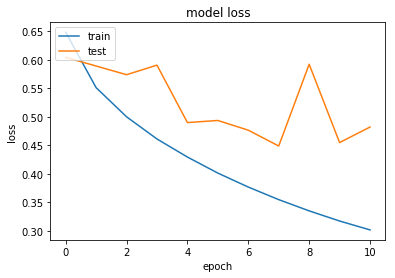

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.900823584615953
Root mean squared error:  8.512863917419077
```



### Predict on test set 01 //MAE: 5.889157821847836, RMSE:  8.497000154288683 (best_t) //MAE: 5.888693371306727, RMSE:  8.497089069348604 (best_scale+_t)

In [0]:
#recalculate offset
y_offset = len(y_test)%8
y_offset

4

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.889157821847836
Root mean squared error:  8.497000154288683
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.888693371306727
Root mean squared error:  8.497089069348604
```



### (TESTING) Model data 01 split V2 (patience=5) //MAE: 5.68237983727275, RMSE:  8.29628763704645

In [0]:
#model name:
model_name = "split_01_V2"
model_save_loc = model_saves_folder_location+"model_hypertuning_best_eval_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512, train_patience=5)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  5
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/model_hypertuning_best_eval_split_01_V2.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.93.7.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18118214343986287335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3685793209457406956)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15793923358311510279)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7317057732998516505)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6771577902110752627)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16004372917424812926)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 9819517265170343934)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 6237407344226372420)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 17929760305307736671)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 2573935462581719199)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 7440834548646161247)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099572 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.367787837982178 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099572 [============================>.] - ETA: 0s - loss: 0.6553 - mean_squared_error: 0.6553INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.555607557296753 secs
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.6553 - mean_squared_error: 0.6553INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.200848579406738 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.77342414855957 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 794s 194us/sample - loss: 0.6553 - mean_squared_error: 0.6553 - val_loss: 0.6902 - val_mean_squared_error: 0.6902
Epoch 2/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.5552 - mean_squared_error: 0.5552INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 751s 183us/sample - loss: 0.5552 - mean_squared_error: 0.5551 - val_loss: 0.5320 - val_mean_squared_error: 0.5320
Epoch 3/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.5038 - mean_squared_error: 0.5038INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 743s 181us/sample - loss: 0.5038 - mean_squared_error: 0.5038 - val_loss: 0.5146 - val_mean_squared_error: 0.5146
Epoch 4/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.4653 - mean_squared_error: 0.4653INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 742s 181us/sample - loss: 0.4654 - mean_squared_error: 0.4654 - val_loss: 0.5143 - val_mean_squared_error: 0.5143
Epoch 5/25
4099572/4099572 [==============================] - 747s 182us/sample - loss: 0.4332 - mean_squared_error: 0.4332 - val_loss: 0.5714 - val_mean_squared_error: 0.5714
Epoch 6/25
4099072/4099572 [============================>.] - ETA: 0s - loss: 0.4059 - mean_squared_error: 0.4059INFO:tensorflow:Copying TPU weights to the CPU
4099572/4099572 [==============================] - 770s 188us/sample - loss: 0.4059 - mean_squared_error: 0.4059 - val_loss: 0.4953 - val_mean_squared_error: 0.4953
Epoch 7/25
3472384/4099572 [========================>.....] - ETA: 1:46 - loss: 0.3803 - mean_squared_error: 0.3803Buffered data was truncated after reaching the output size limit.
```



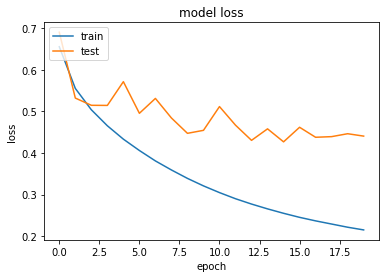

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.68237983727275
Root mean squared error:  8.29628763704645
```



### (TESTING) Predict on test set 01 V2 (patience=5) //MAE: 5.667901161623949, RMSE:  8.272540049018854 //MAE:  5.667341213481646: RMSE: 8.272380421697362 

In [0]:
#recalculate offset
y_offset = len(y_test)%8
y_offset

4

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.667901161623949
Root mean squared error:  8.272540049018854
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.667341213481646
Root mean squared error:  8.272380421697362
```



## Split 02 (best_t, best_h, and best_scaled+_t)

### Create appropriate subset of data 02

In [0]:
del X_train_inner
del y_train_inner
del X_test_inner
del y_test_inner
del standard_scaler_inner
del y_train_scaled_inner
del standard_scaler_test_inner
del y_test_scaled_inner
del y_offset

In [0]:
gc.collect()

792

In [0]:
X_train_inner, X_test_inner = X_train[train_index_02], X_train[test_index_02]
y_train_inner, y_test_inner = y_train[train_index_02], y_train[test_index_02]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099573, 650)
(4099573,)
(2049786, 650)
(2049786,)


In [0]:
y_offset = len(y_test_inner)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

2


### Model data 02 split //MAE: 5.685519417474252, RMSE:  8.364948453697606 (best_h)

In [0]:
#model name:
model_name = "split_02"
model_save_loc = model_saves_folder_location+"model_hypertuning_best_eval_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/model_hypertuning_advanced_split_02.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.45.143.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3551030518299389525)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8232839446518071034)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9113897573489928103)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16972994958359353361)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8090649330443617085)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16207246228950201524)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4991519902735547576)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1455980004123735902)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1036456699446498298)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 1323486629259811591)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 7188960694907138076)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.806702613830566 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6470 - mean_squared_error: 0.6470INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.462904930114746 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6470 - mean_squared_error: 0.6470INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.593617677688599 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.71251654624939 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 782s 191us/sample - loss: 0.6470 - mean_squared_error: 0.6470 - val_loss: 0.6049 - val_mean_squared_error: 0.6049
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5527 - mean_squared_error: 0.5527INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 728s 177us/sample - loss: 0.5527 - mean_squared_error: 0.5527 - val_loss: 0.5637 - val_mean_squared_error: 0.5637
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5033 - mean_squared_error: 0.5033INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 751s 183us/sample - loss: 0.5033 - mean_squared_error: 0.5033 - val_loss: 0.5116 - val_mean_squared_error: 0.5116
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4654 - mean_squared_error: 0.4654INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 737s 180us/sample - loss: 0.4654 - mean_squared_error: 0.4654 - val_loss: 0.4983 - val_mean_squared_error: 0.4983
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4346 - mean_squared_error: 0.4346INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 739s 180us/sample - loss: 0.4346 - mean_squared_error: 0.4346 - val_loss: 0.4850 - val_mean_squared_error: 0.4850
Epoch 6/25
4099573/4099573 [==============================] - 738s 180us/sample - loss: 0.4078 - mean_squared_error: 0.4078 - val_loss: 0.5451 - val_mean_squared_error: 0.5451
Epoch 7/25
3473408/4099573 [========================>.....] - ETA: 1:42 - loss: 0.3837 - mean_squared_error: 0.3837Buffered data was truncated after reaching the output size limit.
```



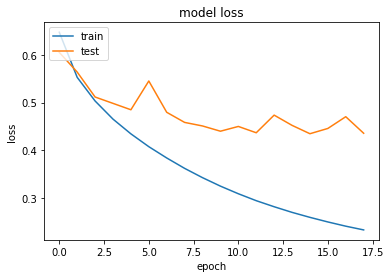

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.685519417474252
Root mean squared error:  8.364948453697606
```



### Predict on test set 02  //MAE: 5.68006176050951, RMSE:  8.353498702460469 (best_t) //MAE: 5.680058580871144, RMSE:  8.353651745317183 (best_scale+_t)

In [0]:
#recalculate offset
y_offset = len(y_test)%8
y_offset

4

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.68006176050951
Root mean squared error:  8.353498702460469
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.680058580871144
Root mean squared error:  8.353651745317183
```



## Split 03 (best_t, best_h, and best_scaled+_t)

### Create appropriate subset of data 03 

In [0]:
del X_train_inner
del y_train_inner
del X_test_inner
del y_test_inner
del standard_scaler_inner
del y_train_scaled_inner
del standard_scaler_test_inner
del y_test_scaled_inner
del y_offset

In [0]:
gc.collect()

792

In [0]:
X_train_inner, X_test_inner = X_train[train_index_03], X_train[test_index_03]
y_train_inner, y_test_inner = y_train[train_index_03], y_train[test_index_03]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099573, 650)
(4099573,)
(2049786, 650)
(2049786,)


In [0]:
y_offset = len(y_test_inner)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

2


### Model data 03 split //MAE: 5.568004964751764, RMSE:  8.296353316985678 (best_h)

In [0]:
#model name:
model_name = "split_03"
model_save_loc = model_saves_folder_location+"model_hypertuning_best_eval_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/model_hypertuning_advanced_split_03.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.45.143.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3551030518299389525)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8232839446518071034)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9113897573489928103)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16972994958359353361)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8090649330443617085)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16207246228950201524)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4991519902735547576)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1455980004123735902)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1036456699446498298)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 1323486629259811591)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 7188960694907138076)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.847074270248413 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6521 - mean_squared_error: 0.6521INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.821752071380615 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6521 - mean_squared_error: 0.6521INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.351946830749512 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.221828937530518 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 800s 195us/sample - loss: 0.6521 - mean_squared_error: 0.6521 - val_loss: 1.0533 - val_mean_squared_error: 1.0533
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5561 - mean_squared_error: 0.5561INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 754s 184us/sample - loss: 0.5561 - mean_squared_error: 0.5561 - val_loss: 0.6327 - val_mean_squared_error: 0.6327
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5040 - mean_squared_error: 0.5040INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 754s 184us/sample - loss: 0.5040 - mean_squared_error: 0.5040 - val_loss: 0.5621 - val_mean_squared_error: 0.5621
Epoch 4/25
4099573/4099573 [==============================] - 753s 184us/sample - loss: 0.4650 - mean_squared_error: 0.4650 - val_loss: 0.6344 - val_mean_squared_error: 0.6344
Epoch 5/25
4099573/4099573 [==============================] - 748s 182us/sample - loss: 0.4331 - mean_squared_error: 0.4331 - val_loss: 0.5935 - val_mean_squared_error: 0.5935
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4058 - mean_squared_error: 0.4058INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 751s 183us/sample - loss: 0.4058 - mean_squared_error: 0.4058 - val_loss: 0.5257 - val_mean_squared_error: 0.5257
Epoch 7/25
3468800/4099573 [========================>.....] - ETA: 1:44 - loss: 0.3802 - mean_squared_error: 0.3802Buffered data was truncated after reaching the output size limit.
```



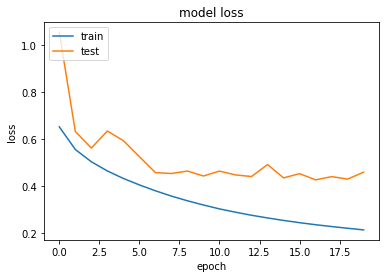

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.568004964751764
Root mean squared error:  8.296353316985678
```



### Predict on test set 03 //MAE: 5.55924757015791, RMSE:  8.286621546087108 (best_t) //MAE:  5.5593684973274735, RMSE: 8.286367007602031 (best_scale+_t)

In [0]:
#recalculate offset
y_offset = len(y_test)%8
y_offset

4

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.55924757015791
Root mean squared error:  8.286621546087108
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.5593684973274735
Root mean squared error:  8.286367007602031
```



## Train+ model

### Create scaled label for test train split

In [0]:
del X_train_inner
del y_train_inner
del X_test_inner
del y_test_inner
del standard_scaler_inner
del y_train_scaled_inner
del standard_scaler_test_inner
del y_test_scaled_inner
del y_offset

In [0]:
gc.collect()

In [0]:
standard_scaler = preprocessing.StandardScaler()
y_train_scaled = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage

standard_scaler_test = preprocessing.StandardScaler()
y_test_scaled= standard_scaler_test.fit_transform(y_test.reshape(-1, 1)).reshape((len(y_test))) #scale y_test seperately

In [0]:
print(X_train.shape)
print(y_train_scaled.shape)
print(X_test.shape)
print(y_test_scaled.shape)

(6149359, 650)
(6149359,)
(1537340, 650)
(1537340,)


In [0]:
y_offset = len(y_test)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

4


### Model test train split //MAE: 5.454390259456975, RMSE:  8.090829165558414 (train+)

In [0]:
#model name:
model_name = "split_train_test"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train, y_train_scaled, X_test[:-y_offset], y_test_scaled[:-y_offset], batch_size=512, train_patience=5)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  5
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/model_hypertuning_advanced_split_train_test.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.24.215.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3276306124262609034)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9166767952360190517)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18402037925273512696)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1987843552644180490)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 442682524076814578)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9692330405279940157)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12468288559044583141)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12634614901219677262)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 15913730728519673584)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 5536081206282554172)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 528947077617645415)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 6149359 samples, validate on 1537336 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.270069599151611 secs
INFO:tensorflow:Setting weights on TPU model.
6148608/6149359 [============================>.] - ETA: 0s - loss: 0.6245 - mean_squared_error: 0.6245INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(29,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(29, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(29, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.475467205047607 secs
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.6245 - mean_squared_error: 0.6245INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.154740571975708 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(39,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(39, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(39, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.313333511352539 secs
INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1133s 184us/sample - loss: 0.6245 - mean_squared_error: 0.6245 - val_loss: 0.5748 - val_mean_squared_error: 0.5748
Epoch 2/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.5202 - mean_squared_error: 0.5202INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1089s 177us/sample - loss: 0.5202 - mean_squared_error: 0.5202 - val_loss: 0.5192 - val_mean_squared_error: 0.5192
Epoch 3/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.4686 - mean_squared_error: 0.4686INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1095s 178us/sample - loss: 0.4686 - mean_squared_error: 0.4686 - val_loss: 0.5122 - val_mean_squared_error: 0.5122
Epoch 4/25
6149120/6149359 [============================>.] - ETA: 0s - loss: 0.4320 - mean_squared_error: 0.4320INFO:tensorflow:Copying TPU weights to the CPU
6149359/6149359 [==============================] - 1096s 178us/sample - loss: 0.4320 - mean_squared_error: 0.4320 - val_loss: 0.4949 - val_mean_squared_error: 0.4949
Epoch 5/25
3416064/6149359 [===============>..............] - ETA: 7:46 - loss: 0.4024 - mean_squared_error: 0.4024Buffered data was truncated after reaching the output size limit.
```



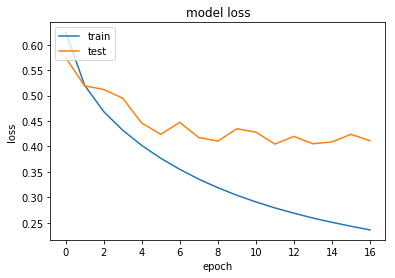

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test[:-y_offset], y_test[:-y_offset], scaler=standard_scaler)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.454390259456975
Root mean squared error:  8.090829165558414
```



# Results:

In [0]:
#just saved everything into one table
train_mae = [5.900823584615953,5.685519417474252,5.568004964751764]
train_rmse = [8.512863917419077,8.364948453697606,8.296353316985678]
test_mae = [5.889157821847836,5.68006176050951,5.55924757015791] #predictions on independent test set
test_rmse = [8.497000154288683,8.353498702460469,8.286621546087108]  #predictions on independent test set
test_mae_whole_scale = [5.888693371306727,5.680058580871144,5.5593684973274735] #standard scaler fit on whole test data
test_rmse_whole_scale = [ 8.497089069348604,8.353651745317183,8.286367007602031] #standard scaler fit on whole test data
test_mae_whole = 5.454390259456975 #early stopping used on test set, otherwise complete train set used for training
test_rmse_whole =  8.090829165558414 #early stopping used on test set, otherwise complete train set used for training

In [0]:
results = pd.DataFrame([train_mae,train_rmse,test_mae,test_rmse,test_mae_whole_scale,test_rmse_whole_scale]).T
results.columns = ["MAE_t","RMSE_t","MAE_h","RMSE_h","MAE_scale+_h","RMSE_scale+_h"]
results.index = ["split_01","split_02","split_03"]
results.describe()

,MAE_t,RMSE_t,MAE_h,RMSE_h,MAE_scale+_h,RMSE_scale+_h
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,5.718116,8.391389,5.709489,8.379040,5.709373,8.379036
std,0.168787,0.110650,0.166912,0.107490,0.166608,0.107630
min,5.568005,8.296353,5.559248,8.286622,5.559368,8.286367
25%,5.626762,8.330651,5.619655,8.320060,5.619714,8.320009
50%,5.685519,8.364948,5.680062,8.353499,5.680059,8.353652
75%,5.793172,8.438906,5.784610,8.425249,5.784376,8.425370
max,5.900824,8.512864,5.889158,8.497000,5.888693,8.497089


In [0]:
results.to_csv(model_saves_folder_location+"hypertuned_cnn_results.csv")

In [0]:
results.describe().to_csv(model_saves_folder_location+"hypertuned_cnn_results_described.csv")

*  As we can see, with train_patience=5 we get more consisten results in the case of plit 01
*  The performance is pretty consistent across the splits
*  The dataset seems to be large enough so that training the scaler on (2/3rd of 4/5th) vs (4/5th) makes no difference 
*  However, using 50% more data significantly improves model performance: by .3 RMSE
*  One could possibly use all data for training if using fixed epoch length between 12-15